<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti bitkoina za naredni dan koriscenjem LSTM**
### **Koraci:**
1. Pretprocesiranje podataka
2. Podela skupa podataka na skupove za trening, validaciju i test
3. Odredjivanje ciljne promenljive za svaki od skupova
4. Skaliranje podataka
5. Kreiranje modela mreze (razmatrana su dva razlicita modela)
6. Treniranje mreze
7. Predvidjanje
8. Evaluacija

Podaci su dati u minutima, a za dalji rad u ovoj svesci koriscene su vrednosti bitkoina po danima. Najpre su podaci grupisani po datumu, a zatim je izracunata prosecna vrednost vrednosti bitkoina (datih za svaki minut) u toku jednog dana (i tako za svaki dan). Skupovi za trening, validaciju i testiranje se sastoje iz ovih, dobijenih, vrednosti bitkoina po danu.

**Ucitavanje biblioteka**

In [309]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

%run Preprocessing.ipynb
%run Utility.ipynb

**Pretprocesiranje**

In [310]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

**Računanje srednje vrednosti cene za svaki datum (dan)**


In [312]:
group = data.groupby('Date')
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


In [313]:
mean_price = group['Weighted_Price'].mean()
mean_price

Date
2011-12-31        4.471603
2012-01-01        4.806667
2012-01-02        5.000000
2012-01-03        5.252500
2012-01-04        5.208159
                  ...     
2021-03-27    55193.357260
2021-03-28    55832.958824
2021-03-29    56913.993819
2021-03-30    58346.912268
2021-03-31    58764.349363
Name: Weighted_Price, Length: 3376, dtype: float64

**Podela skupa podataka**

In [314]:
# Podela podataka na trening, validacioni i test skup

# mean_price - prosecna cena po danima

# Merenja u skupu za treniranje prethode merenjima u validacionom skupu,
# a ona zajedno, prethode merenjima u skupu za testiranje


# Predvidjanje se vrsi za poslednjih prediction_days dana

prediction_days = 60

# Skupovi: train, validation i test

train = mean_price[:len(mean_price) - 2 * prediction_days]
validation = mean_price[len(mean_price) - 2 * prediction_days: len(mean_price) - prediction_days]
test = mean_price[len(mean_price) - prediction_days:]

# Dimenzije skupova

train.shape, validation.shape, test.shape

((3256,), (60,), (60,))

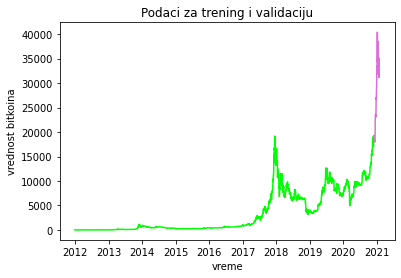

In [342]:
plot_train_and_validation_data(train, validation)

**Odredjivanje ciljne promenljive**

In [316]:
training_set = train.values
validation_set = validation.values
test_set = test.values

In [317]:
training_set

array([4.47160287e+00, 4.80666667e+00, 5.00000000e+00, ...,
       1.79914198e+04, 1.89134780e+04, 1.92647219e+04])

In [318]:
training_set = np.reshape(training_set, (len(training_set), 1))
validation_set = np.reshape(validation_set, (len(validation_set), 1))
test_set = np.reshape(test_set, (len(test_set), 1))

In [319]:
# Skup za treniranje nakon primene np.reshape()

training_set

array([[4.47160287e+00],
       [4.80666667e+00],
       [5.00000000e+00],
       ...,
       [1.79914198e+04],
       [1.89134780e+04],
       [1.92647219e+04]])

In [320]:
# Odredjivanje ciljne promenljive na trening skupu

X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation = validation_set[0:len(validation_set)-1]
y_validation = validation_set[1:len(validation_set)]


# Odredjivanje ciljne promenljive na test skupu

X_test = test_set[0:len(test_set)-1]
y_test = test_set[1:len(test_set)]

In [321]:
X_test.shape, y_test.shape

((59, 1), (59, 1))

In [322]:
X_train[:7]

array([[4.47160287],
       [4.80666667],
       [5.        ],
       [5.2525    ],
       [5.20815931],
       [6.28412715],
       [6.43899905]])

In [323]:
y_train[:7]

array([[4.80666667],
       [5.        ],
       [5.2525    ],
       [5.20815931],
       [6.28412715],
       [6.43899905],
       [6.8       ]])

**Skaliranje podataka**

In [325]:
# Skaliranje podataka skupa za treniranje

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (len(X_train), 1, 1))


# Skaliranje podataka skupa za validaciju

X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (len(X_validation), 1, 1))


# Skaliranje podataka skupa za testiranje

X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (len(X_test), 1, 1))

In [326]:
X_train.shape, y_train.shape

((3255, 1, 1), (3255, 1))

In [327]:
X_train[:5]

array([[[7.29524503e-06]],

       [[2.47630077e-05]],

       [[3.48419862e-05]],

       [[4.80054798e-05]],

       [[4.56938824e-05]]])

In [328]:
y_train[:5]

array([[4.80666667],
       [5.        ],
       [5.2525    ],
       [5.20815931],
       [6.28412715]])

In [329]:
y_test[:5]

array([[33705.97519065],
       [34713.69640011],
       [36573.09481031],
       [37541.54813242],
       [37630.049214  ]])

**Kreiranje i treniranje mreže**

In [330]:
# Inicijalizacija RNN
model = Sequential()

# Dodavanje slojeva
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (None, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units =1))

# Arhitektura mreze
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, None, 50)          10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 60)          26640     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 60)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 80)          45120     
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 80)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 120)              

In [331]:
# Kompilacija RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae'])

# Rano zaustavljanje treninga
callback = callbacks.EarlyStopping(monitor = 'loss', patience = 3)

# Treniranje RNN na trening skupu uz koriscenje validacionog skupa
history = model.fit(X_train, y_train, batch_size = 20, epochs = 50, validation_data = (X_validation, y_validation), verbose = 2, callbacks=[callback])

Epoch 1/50
163/163 - 6s - loss: 27491866.0000 - mse: 27491866.0000 - mae: 3240.5933 - val_loss: 563094208.0000 - val_mse: 563094208.0000 - val_mae: 23063.2207
Epoch 2/50
163/163 - 1s - loss: 7152852.5000 - mse: 7152852.5000 - mae: 2193.2578 - val_loss: 4713951.5000 - val_mse: 4713951.0000 - val_mae: 1752.4603
Epoch 3/50
163/163 - 1s - loss: 2984567.7500 - mse: 2984567.7500 - mae: 1363.9703 - val_loss: 32512450.0000 - val_mse: 32512450.0000 - val_mae: 4492.0571
Epoch 4/50
163/163 - 1s - loss: 2452821.2500 - mse: 2452821.2500 - mae: 1152.7308 - val_loss: 44795252.0000 - val_mse: 44795252.0000 - val_mae: 5458.0288
Epoch 5/50
163/163 - 1s - loss: 2125411.5000 - mse: 2125411.5000 - mae: 1029.6080 - val_loss: 73825312.0000 - val_mse: 73825312.0000 - val_mae: 7310.6167
Epoch 6/50
163/163 - 1s - loss: 2169805.2500 - mse: 2169805.2500 - mae: 948.8442 - val_loss: 43923336.0000 - val_mse: 43923344.0000 - val_mae: 5368.4360
Epoch 7/50
163/163 - 1s - loss: 2061277.7500 - mse: 2061277.7500 - mae: 91

**Predviđanja mreže**

In [332]:
predicted_price = model.predict(X_test)
predicted_price[:5]

array([[36920.36 ],
       [37272.793],
       [38676.336],
       [41310.582],
       [42704.59 ]], dtype=float32)

**Vizuelni prikaz rezultata**

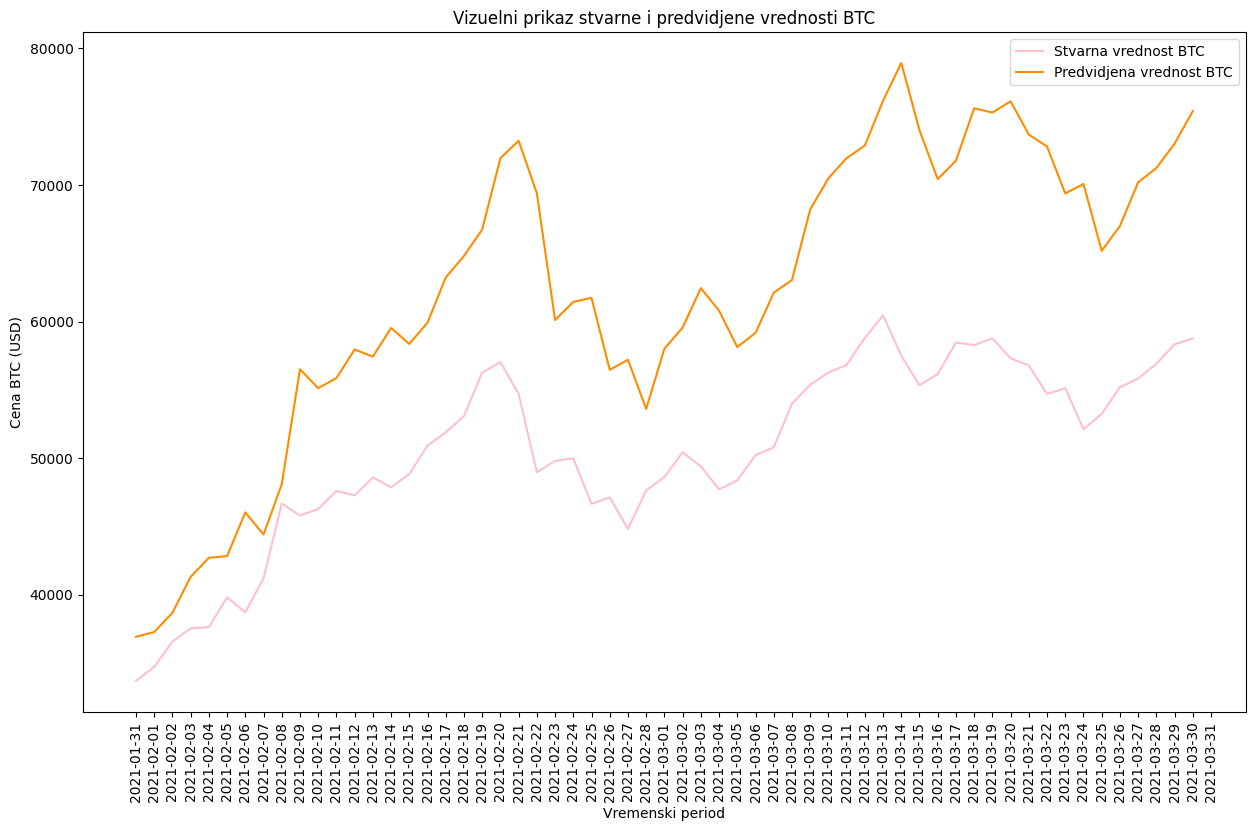

In [335]:
plot_predicted_vs_real_data(real_values = y_test, predicted_values = predicted_price, test_data = test)

**Vizuelni prikaz funkcije gubitka, MSE i MAE tokom treniranja mreze**

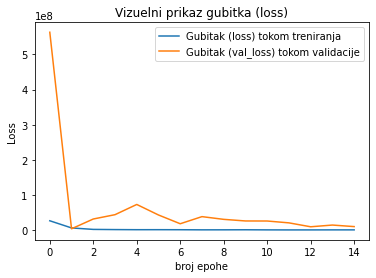

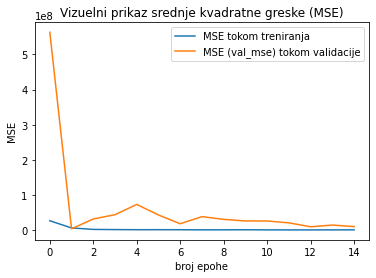

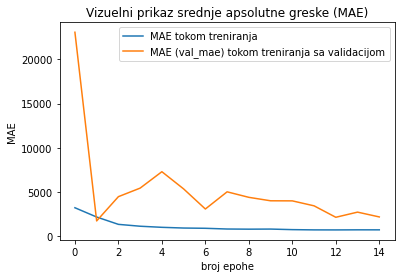

In [337]:
# Loss

plot_loss(history)


# MSE

plot_mse(history)


# MAE

plot_mae(history)

**Funkcija gubitka, MSE i MAE nad skupom za testiranje**

In [343]:
# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_val = model.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja\n')
print(model.metrics_names[0], test_metrics_val[0])
print(model.metrics_names[1], test_metrics_val[1])
print(model.metrics_names[2], test_metrics_val[2])

2/2 [==============================] - 0s 9ms/step - loss: 159045904.0000 - mse: 159045904.0000 - mae: 11667.7539

Metrike prilikom testiranja

loss 159045904.0
mse 159045904.0
mae 11667.75390625


**Koeficijent determinacije (R2 skor)**

In [344]:
r2 = metrics.r2_score(predicted_price, y_test)
print('R2 skor: ', r2)

R2 skor:  -0.35538685650642865
